### pyBlockSeis - Block Choice Seismic Analysis in Python

In [1]:
import sys
sys.path.append("src")

import numpy as np
import pyblockseis as bcs
import matplotlib.pyplot as plt

from obspy.core import read, Stream

%matplotlib inline

### Dataset


**Nuclear explosions from Bondar et al. 2005 (Figure 5)**

| EVID | ORID | NAME | DATE | MSEC | LON | LAT | DEPTH | ML |
| --- | --- | --- | --- | --- | --- | --- | --- | --- |
| 511553 | 3962829 | Clairette | 1981-02-05T18:00:00 | 120 | -116.033 | 37.011 | 0.354 | 3.2 |
| 514907 | 3962836 | Havarti   | 1981-08-05T13:41:00 | 90  | -116.036 | 37.154 | 0.200 | 2.8 |
| 515492 | 3962838 | Trebbiano | 1981-09-04T15:00:00 | 100 | -116.067 | 37.160 | 0.294 | 3.8 |
| 578449 | 3962949 | Tahoka    | 1987-08-13T14:00:00 | 90  | -116.046 | 37.061 | 0.639 | 5.5 |


### Available wavelet processing parameters

* **wave_type**: wavelet filter type, options are ``"morlet"``, ``"shannon"``, ``"mhat"``, ``"hhat"``.
Default is ``"morlet"``.

* **nvoices**: number of voices, or the sampling of CWT in scale.
Higher number of voices give finer resolution. Default is ``16``.

* **bandpass_blocking**: Default value ``True`` will apply a band rejection filter where
wavelet coefficients are modified over a scale bandpass.

* **scale_min**: minimum time scale for bandpass blocking. Default is ``1``.

* **scale_max**: maximum time scale for bandpass blocking. Default is ``200``.

* **block_threshhold:** percent amplitude adjustment to the wavelet coefficients within
``scale_min`` and ``scale_max``. For example a threshold of 5% means the wavelet cofficients
in the band will be multipled by 0.05. Default is ``0``.

* **estimate_noise**: flag to compute the noise model, default is ``True``.

* **noise_starttime**: noise start time, default is ``0``.

* **noise_endtime**: noise end time, default is ``60``.

* **noise_threshold**: type of noise thresholding to be applied, the options are
``"hard"`` for hard thresholding and ``"soft"`` for soft thresholding. Default is ``None``.

* **signal_threshold**: type of signal thresholding to be appied, the options are
``"hard"`` for hard thresholding, and ``"soft"`` for soft thresholding. Default is ``None``.

* **nsigma_method**: method to determine the number of standard deviations for block thresholding.
``"donoho"`` for Donoho's Threshold criterion and ``"ECDF"`` for empirical cumulative probability
distribution method. You can also specify the number of standard deviations by entering a number.
None ECDF method assumes Gaussian statistic. The default method ``"ECDF"`` is recommended.

* **snr_detection**: Flag to apply the SNR detection method, default is ``False``. If ``True`` it
will be applied before hard thresholding.

* **snr_lowerbound**: Noise level percent lower bound. Default is ``1.0``.


In [2]:
# Pre-processing
time_before = 0 # Cut data relative to origin
time_after = 200
sampling_rate = 40

# CWT operations
params = bcs.Parameter(
    scale_min=1.,
    scale_max=100.,
    bandpass_blocking=True,
    block_threshold=5.0,
    noise_endtime=60.,
    noise_threshold="soft",
)

# Create a block object for each event
blocks = []
for evid in [511553, 514907, 515492, 578449]:
    
    # Do some pre-processing to the data
    st = read("testdata/bondar_2015_data/%d/waveforms/*.v"%evid, format="SAC")
    st.resample(40.0)
    for tr in st:
        # Find origin time from SAC header
        origin_time = tr.stats.starttime + (tr.stats.sac.o-tr.stats.sac.b)
        tr.stats.origin_time = origin_time
        tr.trim(origin_time+time_before, origin_time+time_after)
       
    # Initalize and run block object
    block = bcs.read(params=params, data=st)
    block.run()
    blocks.append(block)


In [3]:
for i, block in enumerate(blocks):
    print("Available data for event %d"%i)
    print(block.get_station_list())
    print(block.tags)

Available data for event 0
['.ELK.', '.KNB.', '.LAC.', '.MNV.']
['input', 'band_rejected', 'noise_removed']
Available data for event 1
['.ELK.', '.KNB.', '.LAC.', '.MNV.']
['input', 'band_rejected', 'noise_removed']
Available data for event 2
['.ELK.', '.KNB.', '.LAC.', '.MNV.']
['input', 'band_rejected', 'noise_removed']
Available data for event 3
['.ELK.', '.MNV.']
['input', 'band_rejected', 'noise_removed']


### Comparing CWT and the noise model

You can select data that matches the station criteria:
- network code
- station code
- location code
- channel code
- component code

Example below will plot the results of Elko (ELK) for the first event in the table, Clairette.

Noise model estimated from 'band_rejected' data.


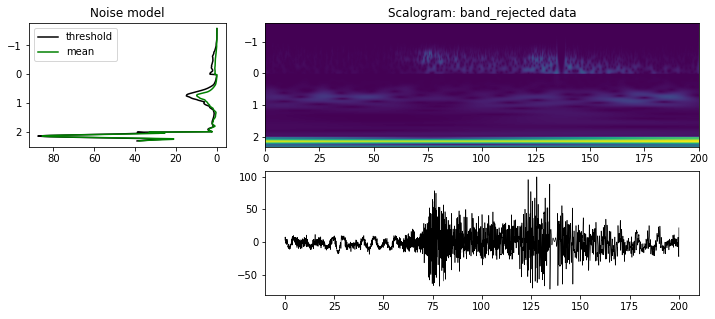

In [4]:
# Get the noise model
# Depending on the processing it can be the "input" waveforms or "band_rejected"
block = blocks[0]
tag = block.noise_model_tag 
print("Noise model estimated from '%s' data."%tag)

# Select the CWT for ELK will return 4 WaveletCollection objects
# for each event
wave = block.get_wavelets(tag).select(station="ELK")[0]

# You can select the seismograms the same way
tr = block.waveforms.data[tag].select(station="ELK")[0]

# Select the first event
scales = np.log10(wave.scales)
threshold = wave.noise_model.P
mean = wave.noise_model.M

fig = plt.figure(figsize=(12,5))
ax1 = plt.subplot2grid((2,3),(0,0))
ax1.plot(threshold, scales,"k",label="threshold")
ax1.plot(mean, scales, "g", label="mean")
ax1.invert_xaxis()
ax1.invert_yaxis()
ax1.legend()
ax1.set_title("Noise model")

# Plot scalogram
extent = [time_before, time_after, max(scales), min(scales)]
ax2 = plt.subplot2grid((2,3),(0,1), colspan=2)
ax2.imshow(abs(wave.coefs), extent=extent, aspect="auto")
ax2.set_title("Scalogram: %s data"%tag)

# Plot waveform
ax3 = plt.subplot2grid((2,3),(1,1), colspan=2)
ax3.plot(tr.times(), tr.data, color="k", linewidth=0.6)

### Denoised data

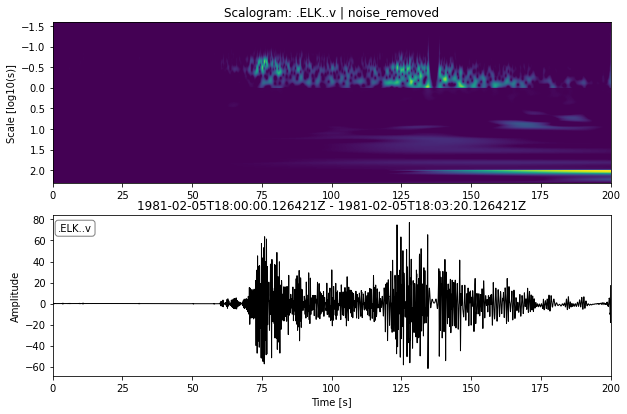

In [5]:
block.plot("noise_removed", station="ELK")

### Write waveform data to file

In [6]:
# Use the write function to save your waveforms to any ObsPy supported
# formats or numpy npz format.

tag = "noise_removed" # save the denoised data
output = "waveforms"

# SAC format
block.write(tag, output=output, format="SAC")

# Numpy npz format (compressed binary)
block.write(tag, output=output, format="npz")

### Write CWT to file

In [7]:
# Save the wavelet transforms, only numpy npz is supported right now

tag = "noise_removed" # save the denoised CWT
output = "cwt"

# Numpy npz format (compressed binary)
block.write(tag, output=output, format="npz")